# RetinaNet implementation
In this notebook you'll find an implementation I did of RetinaNet. The code is not mine, I followed a keras example done by Srihari Humbarwadi. I recommend you to take a look at the link: https://keras.io/examples/vision/retinanet/

In [2]:
# import libraries
import os 
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [3]:
#Download coco2017 dataset. We only use ~500 images for training, instead of 118k
# that coco contains.
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
print(os.getcwd())

keras.utils.get_file(filename, url)

# decompress the dataset with zipfile
with zipfile.ZipFile("data.zip", "r") as z_fp:
  z_fp.extractall("./")

/content


In [4]:
# utility functions
# we need to represent bboxes in two formats:
# [xmin, ymin, xmax, ymax] and [x, y, width, height]. x,y is the center

def swap_xy(boxes):
  '''Swaps order the of x and y coordinates of the boxes.

  Arguments:
    boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

  Returns:
    swapped boxes with shape same as that of boxes.
  '''
  return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


# conver to xywh
def convert_to_xywh(boxes):

  '''Changes the box format to center, width and height.

  Arguments:
    boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
      representing bounding boxes where each box is of the format
      `[xmin, ymin, xmax, ymax]`.

  Returns:
    converted boxes with shape same as that of boxes.
  '''

  return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

# convert to corners
def convert_to_corners(boxes):
  '''Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
  ''' 

  return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

# Next, i'm going to do my own implementation of IoU (cause i want) and his IoU.

In [5]:
# own implementation
def my_own_IoU(boxes1, boxes2):
  '''Computes pairwise IOU matrix for given two sets of boxes'''
  '''
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
      boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
        pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
  '''
  # [xmin, ymin, xmax, ymax]
  boxes1_xy = convert_to_corners(boxes1)
  boxes2_xy = convert_to_corners(boxes2)

  iou = np.zeros((boxes1.shape[0], boxes2.shape[0]))

  for i in range(len(boxes1)):
    area_box1 = (boxes1_xy[i][2]-boxes1_xy[i][0])*(boxes1_xy[i][3]-boxes1_xy[i][1])
    area_box2 = (boxes2_xy[i][2]-boxes2_xy[i][0])*(boxes2_xy[i][3]-boxes2_xy[i][1])
    union = area_box1 + area_box2

    top_left_int = [tf.maximum(boxes1_xy[i][0], boxes2_xy[i][0]),
                      tf.maximum(boxes1_xy[i][1], boxes2_xy[i][1])]
    bottom_right_int = [tf.minimum(boxes1_xy[i][2], boxes2_xy[i][2]),
                      tf.minimum(boxes1_xy[i][3], boxes2_xy[i][3])]

    x = bottom_right_int[0]-top_left_int[0]

    y = bottom_right_int[1]-top_left_int[1]

    x = x if x > 0 else 0
    y = y if y > 0 else 0

    intersection = x * y

    iou[i][i] = intersection / (union - intersection + 1e-8)


  return tf.clip_by_value(iou, 0.0, 1.0)
  

# tf constant and tf maximum examples

In [6]:
x = tf.constant([[1,2], [3,4]])
y = tf.constant([[5,6], [7,8]])

tf.maximum(x, y)
print(x[:,None])

tf.Tensor(
[[[1 2]]

 [[3 4]]], shape=(2, 1, 2), dtype=int32)


In [7]:
def compute_iou(boxes1, boxes2):
    '''Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    '''
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)

    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )

    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    '''Visualize Detections'''
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

# checking and comparing both ious 

In [8]:
gt = tf.constant([[150, 150, 60, 100], [230, 250, 60, 100]], dtype=tf.float32)
det = tf.constant([[170, 180, 60, 100],[210, 215, 60, 100]], dtype=tf.float32)

print(compute_iou(gt, det))
print(my_own_IoU(gt, det))

tf.Tensor(
[[0.3043478  0.        ]
 [0.         0.27659574]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.30434781 0.        ]
 [0.         0.27659574]], shape=(2, 2), dtype=float64)


# Implementing anchor generator

# tf reshape and tf stack examples. list to tensor with tf stack

In [9]:
t = [3, 4]
tf.reshape(t, [1, 1, 2])
t = [[[3, 4]]]
stack = tf.stack(t, axis=-2)
print(stack)
l = [1, 2, 3, 4, 5]
lt = tf.stack(l)
print(lt)

tf.Tensor([[[3 4]]], shape=(1, 1, 2), dtype=int32)
tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)


# public, protected and private variables and functions examples

In [10]:
class test:
  def __init__(self):
    self.public = 1
    self._protected = 2
    self.__private = 3

  def public_function(self):
    return self.public
  
  def _protected_function(self):
    return self._protected
  
  def __private_function(self):
    return self.__private

  def publicf_privatev(self):
    return self.__private

class test2(test):
  def __init__(self):
    test.__init__(self)
  
t = test()
print(t.public) # access
print(t._protected) # access
# print(t.__private) # no access

print(t.public_function()) # yes
print(t._protected_function()) # yes
# print(t.__private_function) # no

print(t.publicf_privatev()) # yes

t2 = test2()
print(t2.public) # access
print(t2._protected) # access
# print(t2.__private) # no access

print(t2.public_function()) # yes
print(t2._protected_function()) # yes
# print(t2.__private_function) # no

1
2
1
2
3
1
2
1
2


# tf range, tf stack and tf meshgrid examples

In [11]:
rx = tf.range(2, dtype=tf.float32)
ry = tf.range(2, dtype=tf.float32)
print(rx)

center = tf.stack(tf.meshgrid(rx, ry), axis=-1) * 2**3
print(center)

tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor(
[[[0. 0.]
  [8. 0.]]

 [[0. 8.]
  [8. 8.]]], shape=(2, 2, 2), dtype=float32)


# tf zeros, tf expand dims examples

In [12]:
image = tf.zeros([1, 1, 3])

exp1 = tf.expand_dims(image, axis=0)
print(exp1.shape)
exp2 = tf.expand_dims(image, axis=1)
print(exp2.shape)
exp3 = tf.expand_dims(image, axis=2)
print(exp3.shape)
exp4 = tf.expand_dims(image, axis=-1)
print(exp4.shape)

(1, 1, 1, 3)
(1, 1, 1, 3)
(1, 1, 1, 3)
(1, 1, 3, 1)


# tf tile

In [13]:
tf.tile(exp3, [1, 1, 9, 1]) # repeat centers num_anchors times

<tf.Tensor: shape=(1, 1, 9, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)>

In [14]:
class AnchorBox:
    '''Generates anchor boxes.

    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.

    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    '''

    def __init__(self):
      self.aspect_ratios = [0.5, 1.0, 2.0] # h/w
      self.scales = [2 ** x for x in [0, 1/3, 2/3]] # different scales to apply 
      # to w and h
      self._num_anchors = len(self.aspect_ratios) * len(self.scales)
      self._strides = [2 ** i for i in range(3, 8)]
      self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
      self._anchor_dims = self._compute_dims()


    def _compute_dims(self):
      '''Computes anchor box dimensions for all ratios and scales at all levels
      of the feature pyramid.
      '''
      anchor_dims_all = []
      # for each area there are 9 anchors for each aspect ratio and scale.
      for area in self._areas:
          anchor_dims = []
          for ratio in self.aspect_ratios:
              # area = w * h
              # ratio = h / w
              anchor_height = tf.math.sqrt(area / ratio)
              anchor_width = area / anchor_height
              # dims [[[w, h]]]
              dims = tf.reshape(
                  tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
              )

              for scale in self.scales:
                  anchor_dims.append(scale * dims)
                  # tf stack here converts a list to a tensor
                  # axis=-2 because [[[]]] 3d
          anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
      
      return anchor_dims_all


    def _get_anchors(self, feature_height, feature_width, level):
      '''Generates anchor boxes for a given feature map size and level

      Arguments:
        feature_height: An integer representing the height of the feature map.
        feature_width: An integer representing the width of the feature map.
        level: An integer representing the level of the feature map in the
          feature pyramid.

      Returns:
        anchor boxes with the shape
        `(feature_height * feature_width * num_anchors, 4)`
      '''
      rx = tf.range(feature_width, dtype=tf.float32) + 0.5
      ry = tf.range(feature_height, dtype=tf.float32) + 0.5

      centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
      centers = tf.expand_dims(centers, axis=-2)
      centers = tf.tile(centers, [1, 1, self._num_anchors, 1])

      dims = tf.tile(
          self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
      )
      
      anchors = tf.concat([centers, dims], axis=-1)
      
      return tf.reshape(
          anchors, [feature_height * feature_width * self._num_anchors, 4]
      )
      

    def get_anchors(self, image_height, image_width):
        '''Generates anchor boxes for all the feature maps of the feature pyramid.

        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.

        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        '''
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]

        return tf.concat(anchors, axis=0)

# Preprocessing data

In [15]:
def random_flip_horizontal(image, boxes):
    '''Flips image and boxes horizontally with 50% chance

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.

    Returns:
      Randomly flipped image and boxes
    '''
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )

    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    '''Resizes and pads image while preserving aspect ratio.

    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.

    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    '''

    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )

    return image, image_shape, ratio


def preprocess_data(sample):
    '''Applies preprocessing step to a single sample

    Arguments:
      sample: A dict representing a single training sample.

    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    '''
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)


    # multiply bbox by image shape because bbox was normalised.
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    
    bbox = convert_to_xywh(bbox)

    return image, bbox, class_id

# Encoding labels

In [16]:
class LabelEncoder:
    '''Transforms the raw labels into targets for training.

    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.

    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    '''

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        '''Matches ground truth boxes to anchor boxes based on IOU.

        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.

        Arguments:
          anchor_boxes: A float tensor with the shape `(total_anchors, 4)`
            representing all the anchor boxes for a given input image shape,
            where each anchor box is of the format `[x, y, width, height]`.
          gt_boxes: A float tensor with shape `(num_objects, 4)` representing
            the ground truth boxes, where each box is of the format
            `[x, y, width, height]`.
          match_iou: A float value representing the minimum IOU threshold for
            determining if a ground truth box can be assigned to an anchor box.
          ignore_iou: A float value representing the IOU threshold under which
            an anchor box is assigned to the background class.

        Returns:
          matched_gt_idx: Index of the matched object
          positive_mask: A mask for anchor boxes that have been assigned ground
            truth boxes.
          ignore_mask: A mask for anchor boxes that need to by ignored during
            training
        '''
        # computes iou, calculating the matrix like this:
        #                   gt boxes
        #                   1     2   3 ...
        #               1   iou1  0   0 ...
        # anchor boxes  2    0   iou2 0 ...
        #               3    0    0   iou3 ...
        #               .    .    . 
        #               .    .    .
        #               .    .    .

        iou_matrix = compute_iou(anchor_boxes, gt_boxes)

        # now, gets the maximum value in each row to take only iou values
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        # also, gets the index of the column where iou value is in each row
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        # now, we have a tensor with iou values [iou1, iou2, iou3, ...],
        # we calculate a true-false mask comparing these values with match_iou (0.5)
        # the remaining true values correspond to the anchor boxes assigned to gt boxes
        positive_mask = tf.greater_equal(max_iou, match_iou)
        # we repeat the same process but to get inferior values than 0.4. These
        # bboxes will be labelled as background.
        negative_mask = tf.less(max_iou, ignore_iou)

        # in positive_mask we have assigned bboxes with true values, 
        # and in negative_mask we have background bboxes. we calculate the
        # or to get all the bboxes with true values. Then, with the logical
        # not, we get those ignored anchor boxes.
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    # transforms x,y,w,h format into representation encoding with variance
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        '''Transforms the ground truth boxes into targets for training'''
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        
        return box_target
        

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        '''Creates box and classification targets for a single sample'''
        # get anchors create the pyramid of levels, then for each level,
        # _get_anchors calculates all the anchor boxes with different areas, 
        # ratios and scales.
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        # integer ids to float
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        
        # match anchor boxes returns the idx of the assigned ground truth boxes,
        # the positive mask (vector of booleans i think) with true values where
        # iou (gt-anchor) is > 0.5 and false if < 0.5, and negative mask with
        # true values where iou < 0.5 and > 0.4 and false in other case.
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        
        # i don't understand (yet!) the usage of matched_gt_boxes. I mean, 
        # if you have the iou matrix like above, this filter is not going
        # to do anything. I mean, if I take the argmax, the iou is the max
        # value always, even if it is equal to zero, you can take iou value.
        # Then, why to do argmax and now tf.gather, instead of just create a 
        # vector [0,1,2,3,.., size]. Here when iou is 0, takes the first one.
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        
        # encoding with variance of bounding boxes
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        
        # the same with classes
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        
        # returns -1 when tf.not... is true, and the correspondent
        # element of matched_gt_cls_ids when false. Tf.not.... is
        # true when iou values of a pair is < 0.5
        # then, we have a vector with -1 if iou <0.5 and the id label
        # if iou is >0.5
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        
        # here we do the same but with iou values between 0.4 and 0.5. Finally,
        # we have that iou values between 0.4 and 0.5 have -2 id labels, iou 
        # values smaller than 0.4 have -1 id labels and >0.5 the id label of the
        # class
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        
        # add a single (1) dimension 
        cls_target = tf.expand_dims(cls_target, axis=-1)
        # concat each box encoded with the target
        label = tf.concat([box_target, cls_target], axis=-1)
        
        return label


    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        '''Creates box and classification targets for a batch'''
        
        # calculating (num_images, shape_images)
        images_shape = tf.shape(batch_images)
        # batch size is num_images
        batch_size = images_shape[0]

        # tf tensor array creates a dynamic-size array, we don't have
        # to declare the size at the beginning as in normal np arrays
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        
        
        for i in range(batch_size):
            # calculates bbox encoded and class label id filtered for each 
            # image, gt and class id
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            # saves it in the dynamic-size array
            labels = labels.write(i, label)
        # apply preprocessing funtions (from resnet paper)    
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        
        # return preprocessed batch_images and a normal tensor with the labels
        return batch_images, labels.stack()

# checking matched gt idx

In [17]:
gt = tf.constant([[150, 150, 60, 100], [230, 250, 60, 100]], dtype=tf.float32)
det = tf.constant([[150, 150, 60, 100],[210, 215, 60, 100]], dtype=tf.float32)

x = LabelEncoder()
x._match_anchor_boxes(det, gt)


(<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>)

# Building the ResNet50 backbone

In [18]:
def get_backbone():
    '''Builds ResNet50 with pre-trained imagenet weights'''
    # resnet50 model, wth final layer, colour images
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    '''Not only the batch dimension can be None, but many others as well.
      For instance, in a 2D convolutional network, where the expected input is 
      (batchSize, height, width, channels), you can have shapes like (None, None, None, 3), 
      allowing variable image sizes. '''
    # feature maps at strides 8, 16, 32. here is where we extract features from
    # the fpn to detect and classify in these three levels of features
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    # return one model with the inputs of resnet50 and three outputs
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

# Build feature pyramid network as a custom layer

# __call__ method example

In [19]:
class Example:
  
  def __init__(self):
    print("instance created!")
  
  def __call__(self):
    return "instance called via call method!"

e = Example()
print(e())

class Example2:
  
  def __init__(self):
    print("instance created!")
  
  def __call__(self, a):
    return "instance called via call method!, param {}".format(a)

e2 = Example2()
print(e2(5))

instance created!
instance called via call method!
instance created!
instance called via call method!, param 5


In [20]:
class FeaturePyramid(keras.layers.Layer):
    '''Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    '''

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        # remember keras calls __call__ method of layer class and then
        # in __call__, this call method is called.
        # to understand the layers below, see the structure of the pyramid
        # in the original paper
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        
        return p3_output, p4_output, p5_output, p6_output, p7_output

# Building the classification and box regression heads
The RetinaNet model has separate heads for bounding box regression and for predicting probabilities for the objects. These heads are shared between all the feature maps of the feature pyramid.

In [21]:
def build_head(output_filters, bias_init):
    '''Builds the class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.

    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    '''
    # remember that none, none here is used to indicate that we
    # don't know the input shape and it's variable. The number 256 here
    # is because all the convolutions use 256 filters, so we'll have 256
    # "images" of hxw.
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    # easy: conv2d, relu, conv2d, relu... four times
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    # final layer of the classifier
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )

    return head

In [22]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
values = initializer(shape=(2, 2))
print(values)

tf.Tensor(
[[0.8751914  0.24422759]
 [0.39565757 1.6019548 ]], shape=(2, 2), dtype=float32)


# Building RetinaNet using a subclassed model

In [23]:

class RetinaNet(keras.Model):
    '''A subclassed Keras model implementing the RetinaNet architecture.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    '''

    def __init__(self, num_classes, backbone=None, **kwargs):
        # super recieves the name of the class as the first argument
        # only in python2
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        # here we create the model of fpn class
        self.fpn = FeaturePyramid(backbone)
        # define number of classes
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        # here we define both heads for classification and bbox regression.
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        # here we call the call method from fpn class, and this method
        # will return 7 feature maps with different sizes
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        # we extract bboxes and classifications for each feature map
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )

        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)

        return tf.concat([box_outputs, cls_outputs], axis=-1)

# Implementing a custom layer to decode predictions

In [24]:
class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.

    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=80,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    # the inverse operation that we did in _compute_box_target in label encoder
    # class
    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed


    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)

        # creates all the different anchors (scale, ratio, area) for each
        # of the feature maps
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        # gets predictions and classifications
        # i don't understand the usage of the sigmoid function here
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

# Implementing Smooth L1 loss and Focal Loss as Keras custom losses

In [25]:
# loss for bounding boxes
class RetinaNetBoxLoss(tf.losses.Loss):
    '''Implements Smooth L1 loss'''

    '''
    Smooth L1 loss is a piecewise function:
    0.5 * x^2 if |x| < delta else |x| - 0.5
    '''

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):

        # x
        difference = y_true - y_pred
        # |x|
        absolute_difference = tf.abs(difference)
        # x^2
        squared_difference = difference ** 2
        # remember that tf where function returns the
        # second param if the first param is true, or
        # the third param if the first one is False.
        # Thus, it will return 0.5 * x^2 if |x| < delta,
        # and |x| if |x| > delta
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )

        # i suppose that the sum is because we call this function with 
        # a batch of predictions, then you have to do the summatory

        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    '''Implements Focal loss'''

    '''
    FL(pt) = -alpha * (1-pt)^gamma * log(pt)

    cross_entropy here is log(pt)

    pt is p (predicted probability) if y (ground truth) == 1
    else pt = 1-p

    '''


    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma


    def call(self, y_true, y_pred):
        # log(pt)
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        # p
        probs = tf.nn.sigmoid(y_pred)
        # alpha
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        # pt is p or 1-p
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        # complete formula
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        
        # the summatory operation for each pair of y_pred and y_true
        return tf.reduce_sum(loss, axis=-1)


# combination of two losses
class RetinaNetLoss(tf.losses.Loss):
    '''Wrapper to combine both the losses'''

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):

        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        
        # creating one object of each class
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes


    def call(self, y_true, y_pred):
        # convert prediction in float type
        y_pred = tf.cast(y_pred, dtype=tf.float32)

        # get box labels and predictions
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        
        # one hot encode
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )

        # class predictions
        cls_predictions = y_pred[:, :, 4:]
        # REMEMBER THIS:
        # here we do the same but with iou values between 0.4 and 0.5. Finally,
        # we have that iou values between 0.4 and 0.5 have -2 id labels (ignore),
        # iou values smaller than 0.4 have -1 id labels (background) and >0.5 the id 
        # label of the class
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        
        # ignore_mask contains 1s if y_true label is equal to -2.0
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        
        # calculate classification and bbox loss
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        
        box_loss = self._box_loss(box_labels, box_predictions)
        
        # ignore the loss when the label is from ignore mask group
        # we only take into account the loss if the label is from a 
        # class or the label is backbround (remember that we set 
        # background labels to -1)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        
        # for box loss calculation, we only take into account iou values
        # greater than 0.5 between gt and anchor
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        
        # it's like doing len of the values == 1
        # i have a doubt here: from my point of view, we should 
        # create two normalizers, one for clf_loss and another for box_loss.
        # The reason is that positive_mask only takes into account pairs
        # of anchor-gtbox with iou>0.5. It doesn't take into account background.
        # Then, in clf_loss we do take into account background labels, so
        # there are more labels in clf_loss than in box_loss. (i think)
        # I THINK HERE WE ARE NOT USING BACKGROUND LABELS AND I DON'T KNOW WHY
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = clf_loss + box_loss
        
        return loss

# Setting up training parameters

In [26]:
model_dir = "retinanet/"
# we create an object of LabelEncoder class because we have to normalise all the 
# ground truth bounding boxes
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]

learning_rate_boundaries = [125, 250, 500, 240000, 360000]
# this scheduler allows us to change the learning rate in a fixed number of 
# epochs
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

#Initializing and compiling model

In [27]:
resnet50_backbone = get_backbone()

loss_fn = RetinaNetLoss(num_classes)

model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

model.compile(loss=loss_fn, optimizer=optimizer)

#Setting up callbacks

In [28]:
callbacks_list = [
                  tf.keras.callbacks.ModelCheckpoint(
                    filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
                    monitor="loss",
                    save_best_only=False,
                    save_weights_only=True,
                    verbose=1, 
                  )
]

# Load the COCO2017 dataset using TensorFlow Datasets

In [29]:
# set data_dir = None to load the complete dataset

(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)
print(train_dataset)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>


#Setting up a tf.data pipeline

To ensure that the model is fed with data efficiently we will be using tf.data API to create our input pipeline. The input pipeline consists for the following major processing steps:

  -Apply the preprocessing function to the samples.

  -Create batches with fixed batch size. Since images in the batch can have different dimensions, and can also have different number of objects, we use padded_batch to the add the necessary padding to create rectangular tensors.
  
  -Create targets for each sample in the batch using LabelEncoder

In [30]:
def show(A):
  for element in A.as_numpy_iterator():
    print(element)

# example of padded_batch
# create a dataset with a single value from 1 to 4
A = (tf.data.Dataset.range(1, 5, output_type=tf.int32))
show(A)
# apply lambda function to every single value in A
# tf fill creates a tensor with the dimension of the first param, and the values
# of the second
A_map = A.map(lambda x: tf.fill([x], 9))
show(A_map)

A_map2 = A.map(lambda x: tf.fill([8], x))
show(A_map2)

A_map3 = A.map(lambda x: tf.fill([x], x))
show(A_map3)

C = A_map.padded_batch(2, padded_shapes=5)
show(C)

C2 = A_map.padded_batch(2, padded_shapes=5, padding_values=(-1))
show(C2)

1
2
3
4
[9]
[9 9]
[9 9 9]
[9 9 9 9]
[1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2]
[3 3 3 3 3 3 3 3]
[4 4 4 4 4 4 4 4]
[1]
[2 2]
[3 3 3]
[4 4 4 4]
[[9 0 0 0 0]
 [9 9 0 0 0]]
[[9 9 9 0 0]
 [9 9 9 9 0]]
[[ 9 -1 -1 -1 -1]
 [ 9  9 -1 -1 -1]]
[[ 9  9  9 -1 -1]
 [ 9  9  9  9 -1]]


In [31]:
autotune = tf.data.AUTOTUNE
# map applies a function (in parallel) to every element of the dataset 
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
# shuffle data 
train_dataset = train_dataset.shuffle(8 * batch_size)
# apply padding if elements have different shapes (imgs with different sizes)
# padding_values is the value that we use to fill the voids when padding
# (dim1, dim2, dim3) rgb images, 3 channels
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)

train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

# create the dataset ignoring possible errors
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

# this is really important for speeding up the training
# prefetch function loads and executes the preprocessing in the following batch
# while the GPU is training with the current batch
train_dataset = train_dataset.prefetch(autotune)

# the same but with validation data
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

#Training the model

In [32]:
# Uncomment the following lines, when training on full dataset
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 1

# Running 100 training and 50 validation steps,
# remove `.take` when training on the full dataset

model.fit(
    train_dataset.take(100),
    steps_per_epoch=50,
    validation_data=val_dataset.take(50),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

50/50 [==============================] - ETA: 0s - loss: 4.0422
Epoch 1: saving model to retinanet/weights_epoch_1
50/50 [==============================] - 393s 7s/step - loss: 4.0422 - val_loss: 4.0921


#Loading weights

In [33]:
# Change this to `model_dir` when not using the downloaded weights
weights_dir = "data"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

#Building inference model

In [34]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

# Generating detections

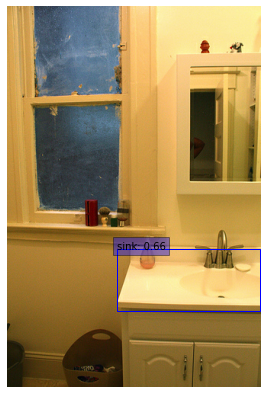

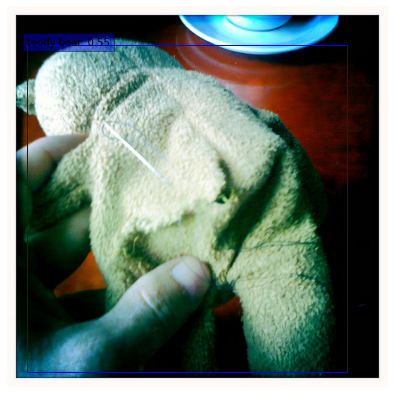

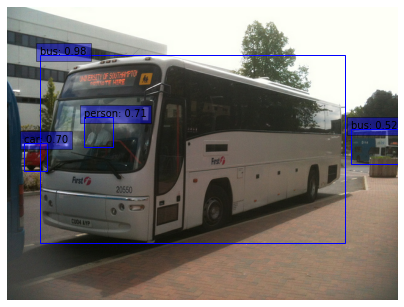

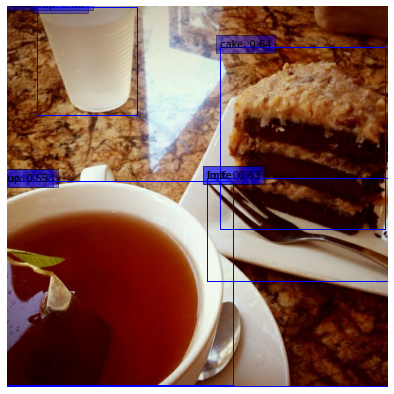

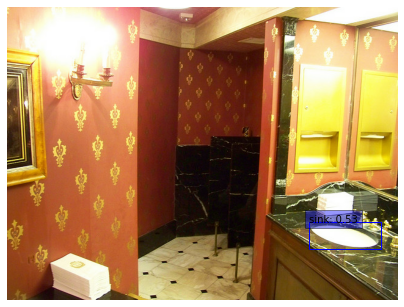

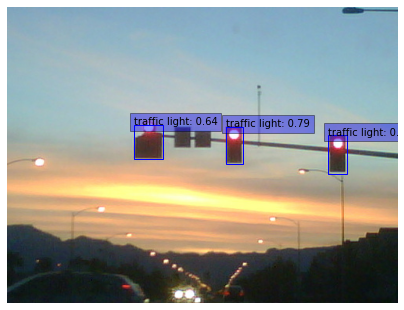

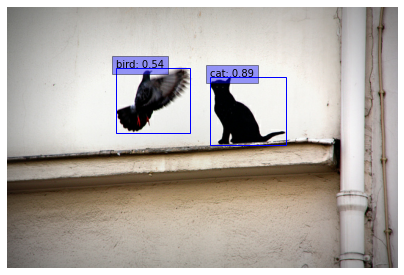

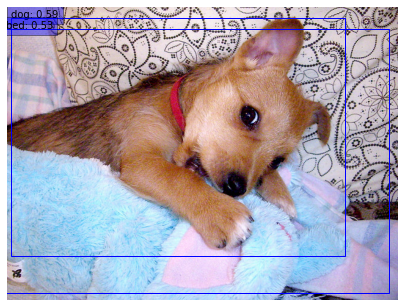

In [35]:

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio


val_dataset = tfds.load("coco/2017", split="test", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str

for sample in val_dataset.take(8):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )